# <FONT SIZE=6 COLOR="purple"> **Proyecto Final PLN** </FONT>

## <FONT SIZE=4 COLOR="blue"> **Instalación y Carga de Liberías** </FONT>

In [1]:
#! pip install keras tensorflow transformers sentencepiece wordcloud stop-words pyLDAvis -q

In [2]:
# Cargamos las librerias necesarias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim
import re
import seaborn as sns
import warnings

from gensim import  corpora
from gensim.models import TfidfModel, LdaModel, CoherenceModel
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Flatten
from wordcloud import WordCloud

warnings.filterwarnings(action='ignore')

# <FONT SIZE=5 COLOR="bronw"> **Exploración de los datos** </FONT>

## <FONT SIZE=4 COLOR="blue"> **1. Carga y Descripción de los datos** </FONT>

Utilizando la librería Pandas, se realiza la carga del conjunto de datos desde el archivo `Wine_Reviews.csv`. Posteriormente, se imprime una descripción breve y esencial del conjunto de datos mediante `data.info()` y `data.describe()`. Permitiendo tener una visión general de la estructura de los datos, incluyendo la cantidad de registros, el tipo de datos en cada columna y estadísticas descriptivas relevantes para columnas numéricas, como la media, desviación estándar, y valores mínimos y máximos.

In [3]:
data = pd.read_csv('data/Wine_Reviews.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [5]:
data.describe()

,Unnamed: 0,points,price
count,129971.000000,129971.000000,120975.000000
mean,64985.000000,88.447138,35.363389
std,37519.540256,3.039730,41.022218
min,0.000000,80.000000,4.000000
25%,32492.500000,86.000000,17.000000
50%,64985.000000,88.000000,25.000000
75%,97477.500000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


In [6]:
data.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


**Agregar una buena descripción de los datos**

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nulla et rhoncus ligula, varius gravida arcu. Proin vitae massa pharetra, commodo mi quis, bibendum sem. Nunc aliquet magna sit amet massa auctor, et pulvinar leo consectetur. Mauris ullamcorper mi non enim condimentum semper. Integer tempus, orci id ultricies euismod, nunc dui dictum velit, a venenatis tellus nisl vel tellus. Suspendisse vulputate rutrum porttitor. Vestibulum sed leo blandit, posuere ligula vel, varius turpis. Proin erat ipsum, rutrum in orci nec, pharetra blandit nunc. Cras magna orci, dapibus non porttitor et, auctor et lacus. Nunc quis libero neque. 

Nulla dui dolor, pretium vitae malesuada at, ultrices eget nibh. Aenean dapibus iaculis orci, ornare suscipit ex gravida vitae. Donec laoreet eleifend ligula, eu dignissim urna lacinia ac. Donec euismod turpis ex, nec convallis lectus lacinia nec. Fusce vel ipsum ut velit aliquam auctor. Curabitur commodo mollis sem. Proin scelerisque erat sed condimentum imperdiet. Mauris nisi neque, bibendum vitae placerat nec, eleifend nec urna. Lorem ipsum dolor sit amet, consectetur adipiscing elit. 

Concluir con que se eliminaran las demás variables, diferentes a `description` y `variety`.

In [4]:
data = data.drop(columns=['Unnamed: 0', 'country', 'designation', 'points',
                          'price', 'province', 'region_1', 'region_2', 'taster_name',
                          'taster_twitter_handle', 'title', 'winery'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  129971 non-null  object
 1   variety      129970 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


## <FONT SIZE=4 COLOR="blue"> **2. Análisis de la Variable 'variety'** </FONT>

Se realiza un análisis sobre las variedades de vino presentes en el conjunto de datos, en la columna `variety`. Luego, se utiliza `value_counts()` para calcular la frecuencia de ocurrencia de cada variedad y se seleccionan las 10 variedades más comunes (`variety_counts.head(10)`). Finalmente, se crea un gráfico de barras para visualizar la distribución de estas 10 variedades, permitiendo una comprensión visual rápida de las 10 variedades de vino más prevalentes en el conjunto de datos.

In [12]:
variety_counts = data['variety'].value_counts()
top_10_varieties = variety_counts.head(10).reset_index(name='count')
fig = px.bar(top_10_varieties, x='index', y='count',
              labels={'index': 'Variety', 'count': 'Frequency'},
              title='Top 10 Wine Varieties')
fig.update_xaxes(title_font=dict(size=18), tickfont=dict(size=14))
fig.update_yaxes(title_font=dict(size=18), tickfont=dict(size=14))
fig.update_layout(title_font=dict(size=20))
fig.show()

**Agregar una buena descripción de la distribución de los datos**

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nulla et rhoncus ligula, varius gravida arcu. Proin vitae massa pharetra, commodo mi quis, bibendum sem. Nunc aliquet magna sit amet massa auctor, et pulvinar leo consectetur. Mauris ullamcorper mi non enim condimentum semper. Integer tempus, orci id ultricies euismod, nunc dui dictum velit, a venenatis tellus nisl vel tellus. Suspendisse vulputate rutrum porttitor. Vestibulum sed leo blandit, posuere ligula vel, varius turpis. Proin erat ipsum, rutrum in orci nec, pharetra blandit nunc. Cras magna orci, dapibus non porttitor et, auctor et lacus. Nunc quis libero neque. 

Nulla dui dolor, pretium vitae malesuada at, ultrices eget nibh. Aenean dapibus iaculis orci, ornare suscipit ex gravida vitae. Donec laoreet eleifend ligula, eu dignissim urna lacinia ac. Donec euismod turpis ex, nec convallis lectus lacinia nec. Fusce vel ipsum ut velit aliquam auctor. Curabitur commodo mollis sem. Proin scelerisque erat sed condimentum imperdiet. Mauris nisi neque, bibendum vitae placerat nec, eleifend nec urna. Lorem ipsum dolor sit amet, consectetur adipiscing elit. 

## <FONT SIZE=4 COLOR="blue"> **3. Selección y Filtrado de Datos Relevantes** </FONT>

Se seleccionan las 10 variedades más comunes y se extraen 2000 registros aleatorios de cada una para construir un nuevo conjunto de datos denominado `filtered_data`. Usando esta información, se seleccionan 2000 registros aleatorios por cada variedad de vino, almacenandose en un nuevo conjunto llamado `final_data`. Así, se logra obtener una cantidad equilibrada de muestras de las 10 variedades principales.

In [13]:
top_10_list = top_10_varieties["index"].tolist()
filtered_data = data[data['variety'].isin(top_10_list)]
final_data = pd.DataFrame()
for variety in top_10_list:
    variety_data = filtered_data[filtered_data['variety'] == variety]
    sample = variety_data.sample(n=2000, random_state=1)
    final_data = pd.concat([final_data, sample])
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 120724 to 111652
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  20000 non-null  object
 1   variety      20000 non-null  object
dtypes: object(2)
memory usage: 468.8+ KB


## <FONT SIZE=4 COLOR="blue"> **4. Normalización y Almacenamiento de Datos Limpios** </FONT>

Se lleva a cabo una limpieza de las descripciones de vinos en la columna `description` de `final_data`. Se define una función `clean_description` que realiza operaciones de limpieza en el texto de las descripciones de vinos. Esta función convierte todo el texto a minúsculas, elimina caracteres no alfabéticos y palabras vacías, utilizando la biblioteca `nltk`. Luego, se aplica esta función a la columna `description` y se guarda el resultado en un archivo `clean_descriptions.pickle`. Dejando los datos listos para análisis y modelos de procesamiento de lenguaje natural.

In [10]:
def clean_description(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

In [11]:
final_data['description'] = final_data['description'].apply(clean_description)
final_data.head(2)

,description,variety
120724,testarossa blends wine grapes sourced multiple...,Pinot Noir
27339,fabulous example light balanced wine santa luc...,Pinot Noir


In [12]:
with open('data/clean_descriptions.pickle', 'wb') as f:
    pickle.dump(final_data, f)

In [14]:
with open('data/clean_descriptions.pickle', 'rb') as f:
    data = pickle.load(f)
data.head(1)

,description,variety
120724,testarossa blends wine grapes sourced multiple...,Pinot Noir


## <FONT SIZE=4 COLOR="blue"> **5. Visualización con Nube de Palabras** </FONT>

Finalmente, se crea una nube de palabras a partir de las descripciones limpias de vinos, lo que proporciona una representación visual de las palabras más frecuentes en estas descripciones. Para esto se unen todas las descripciones limpias en un solo texto y se utiliza la biblioteca `wordcloud` para generar la visualización. Permitiendo identificar patrones o términos dominantes en los datos.

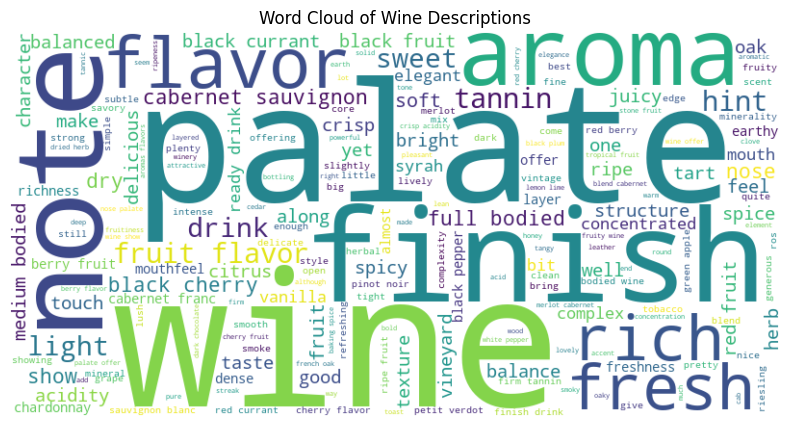

In [14]:
text = ' '.join(data['description'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Wine Descriptions')
plt.show()

**Agregar texto para la nube de palabras**

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nulla et rhoncus ligula, varius gravida arcu. Proin vitae massa pharetra, commodo mi quis, bibendum sem. Nunc aliquet magna sit amet massa auctor, et pulvinar leo consectetur. Mauris ullamcorper mi non enim condimentum semper. Integer tempus, orci id ultricies euismod, nunc dui dictum velit, a venenatis tellus nisl vel tellus. Suspendisse vulputate rutrum porttitor. Vestibulum sed leo blandit, posuere ligula vel, varius turpis. Proin erat ipsum, rutrum in orci nec, pharetra blandit nunc. Cras magna orci, dapibus non porttitor et, auctor et lacus. Nunc quis libero neque. 

Nulla dui dolor, pretium vitae malesuada at, ultrices eget nibh. Aenean dapibus iaculis orci, ornare suscipit ex gravida vitae. Donec laoreet eleifend ligula, eu dignissim urna lacinia ac. Donec euismod turpis ex, nec convallis lectus lacinia nec. Fusce vel ipsum ut velit aliquam auctor. Curabitur commodo mollis sem. Proin scelerisque erat sed condimentum imperdiet. Mauris nisi neque, bibendum vitae placerat nec, eleifend nec urna. Lorem ipsum dolor sit amet, consectetur adipiscing elit. 

# <FONT SIZE=5 COLOR="bronw"> **Modelos ML and RNN** </FONT>

## <FONT SIZE=4 COLOR="blue"> **1. Codificación de la Variable Objetivo** </FONT>

Se lleva a cabo un paso inicial de preprocesamiento al aplicar `LabelEncoder` a la variable categórica `variety` para transformarla en una forma numérica que puede ser interpretada por los modelos.

In [15]:
label_encoder = LabelEncoder()
data['variety_encoded'] = label_encoder.fit_transform(data['variety'])
data.sample(3)

,description,variety,variety_encoded
64593,young freshly fruity wine gassy berry cherry l...,Red Blend,5
45286,intense wild berry pomegranate fruit anchors s...,Syrah,9
38210,varietal cuv e smoky supple detailed first sni...,Syrah,9


## <FONT SIZE=4 COLOR="blue"> **2. División de Datos para Entrenamiento y Prueba** </FONT>

Luego, el conjunto de datos se divide en conjuntos de entrenamiento y prueba mediante `train_test_split` de `Scikit-Learn`. Este paso resulta en la segmentación de las descripciones de vinos (`data['description']`) como las características a utilizar (`X_train`, `X_test`), y las variedades codificadas (`data['variety_encoded']`) como las etiquetas correspondientes (`y_train`, `y_test`).

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data['description'], data['variety_encoded'], test_size=0.2, random_state=0)

## <FONT SIZE=4 COLOR="blue"> **3. Tokenización de los datos** </FONT>

Se procede a preparar los datos para los modelos. Primero, se emplea la clase `Tokenizer` de Keras para convertir las descripciones de texto en secuencias numéricas. Luego, se ajusta la longitud de las secuencias utilizando `pad_sequences` con el fin de estandarizarlas a una longitud máxima (`max_len`). Para el modelo LSTM, también se especifica un número máximo de palabras (`max_words`).

In [17]:
max_words = 5000
max_len = 200
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

## <FONT SIZE=4 COLOR="blue"> **4. Configuración de los Modelos** </FONT>

Se definen y entrenan dos modelos distintos de redes neuronales, uno basado en un Perceptrón Multicapa (MLP) y otro en una red neuronal de tipo LSTM (Long Short-Term Memory). Estas arquitecturas son fundamentales en el campo del aprendizaje automático y el procesamiento del lenguaje natural (PLN), cada una con características distintivas que las hacen adecuadas para diferentes tipos de tareas.

El Perceptrón Multicapa (MLP) es un tipo básico de red neuronal artificial en el que las neuronas están dispuestas en capas: una capa de entrada, una o más capas ocultas y una capa de salida. En particular, el modelo MLP está definido utilizando la clase `Sequential` de Keras, con tres capas densas (`Dense`). Las capas densas están totalmente conectadas, lo que significa que cada neurona de una capa está conectada a todas las neuronas de la capa siguiente. Se utilizan funciones de activación ReLU en las capas intermedias para introducir no linealidades y una función de activación softmax en la capa de salida para la clasificación multiclase.

Por otro lado, la red LSTM (Long Short-Term Memory) es un tipo de red neuronal recurrente (RNN) especializada en capturar y recordar dependencias a largo plazo en datos secuenciales. En contraste con las RNN estándar, las LSTM están diseñadas para evitar el problema del desvanecimiento del gradiente, permitiendo que las redes aprendan dependencias temporales más largas. En este caso, el modelo LSTM también utiliza la clase `Sequential` de Keras. Se emplea una capa de `Embedding` para convertir los datos de entrada en vectores densos, seguida de una capa de `SpatialDropout1D` para evitar el sobreajuste en datos secuenciales. La capa `LSTM` principal con dropout y recurrent_dropout ayuda a aprender y recordar patrones complejos en secuencias de datos, seguida de una capa `Dense` con activación softmax para la clasificación de múltiples clases.

Ambos modelos se compilan utilizando el optimizador `adam` y la función de pérdida `sparse_categorical_crossentropy` para la optimización y evaluación del rendimiento durante el entrenamiento. Además, se establece la métrica de precisión (`accuracy`) para evaluar la eficacia de los modelos durante el entrenamiento y la evaluación.

In [103]:
mlp_model = Sequential([
    Flatten(input_shape=(max_len,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [82]:
lstm_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    SpatialDropout1D(0.3),
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## <FONT SIZE=4 COLOR="blue"> **5. Entrenamiento de los Modelos** </FONT>

Ahora, se entrenan los modelos MLP y LSTM con los datos de entrenamiento (`X_train_pad`, `y_train`) proporcionados durante 25 épocas, usando lotes de tamaño 32, y también evalúan su desempeño en los datos de prueba. Dichos modelos son guardados en archivos `.h5`, el formato estándar para guardar modelos en Keras.

In [104]:
mlp_history = mlp_model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/10
500/500 [==============================] - 2s 3ms/step - loss: 23.9982 - accuracy: 0.0961 - val_loss: 2.3469 - val_accuracy: 0.1023
Epoch 2/10
500/500 [==============================] - 1s 3ms/step - loss: 2.3187 - accuracy: 0.0983 - val_loss: 2.3269 - val_accuracy: 0.0960
Epoch 3/10
500/500 [==============================] - 1s 3ms/step - loss: 2.3025 - accuracy: 0.0988 - val_loss: 2.3225 - val_accuracy: 0.0962
Epoch 4/10
500/500 [==============================] - 1s 3ms/step - loss: 2.3011 - accuracy: 0.0976 - val_loss: 2.3177 - val_accuracy: 0.0955
Epoch 5/10
500/500 [==============================] - 1s 3ms/step - loss: 2.3036 - accuracy: 0.0961 - val_loss: 2.3253 - val_accuracy: 0.0950
Epoch 6/10
500/500 [==============================] - 1s 3ms/step - loss: 2.3017 - accuracy: 0.0979 - val_loss: 2.3237 - val_accuracy: 0.0950
Epoch 7/10
500/500 [==============================] - 1s 3ms/step - loss: 2.3025 - accuracy: 0.0991 - val_loss: 2.3286 - val_accuracy: 0.0953
Epoch

In [105]:
mlp_model.save("data/mlp_model.h5")

In [84]:
lstm_history = lstm_model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/10
500/500 [==============================] - 352s 699ms/step - loss: 1.4736 - accuracy: 0.4237 - val_loss: 1.0486 - val_accuracy: 0.6290
Epoch 2/10
500/500 [==============================] - 155s 310ms/step - loss: 0.8793 - accuracy: 0.6826 - val_loss: 0.8461 - val_accuracy: 0.6998
Epoch 3/10
500/500 [==============================] - 159s 318ms/step - loss: 0.6743 - accuracy: 0.7627 - val_loss: 0.8204 - val_accuracy: 0.7247
Epoch 4/10
500/500 [==============================] - 159s 319ms/step - loss: 0.5640 - accuracy: 0.8024 - val_loss: 0.8070 - val_accuracy: 0.7320
Epoch 5/10
500/500 [==============================] - 118s 237ms/step - loss: 0.4793 - accuracy: 0.8369 - val_loss: 0.8128 - val_accuracy: 0.7372
Epoch 6/10
500/500 [==============================] - 118s 236ms/step - loss: 0.4072 - accuracy: 0.8605 - val_loss: 0.8553 - val_accuracy: 0.7365
Epoch 7/10
500/500 [==============================] - 107s 215ms/step - loss: 0.3565 - accuracy: 0.8767 - val_loss: 0.8859 -

In [86]:
lstm_model.save("data/lstm_model.h5")

In [19]:
mlp_model = load_model("data/mlp_model.h5")
lstm_model = load_model("data/lstm_model.h5")

## <FONT SIZE=4 COLOR="blue"> **5. Evaluación y Comparación de los Modelos** </FONT>

Se realiza una evaluación exhaustiva de ambos modelos en el conjunto de prueba (`X_test_pad`, `y_test`), generando predicciones para ambos modelos en el conjunto de prueba (`X_test_pad`). Se elaboran informes de clasificación detallados y matrices de confusión para cada modelo, proporcionando una visión más completa de su rendimiento y capacidades de clasificación. Junto a la visualización de sus métricas como `Accuracy`, `Precision`, `Recall` y `F1_score`.

Para visualizar de manera efectiva la evolución del rendimiento durante el entrenamiento, se crean subgráficos en un diseño de cuadrícula para los cuatro gráficos relevantes. Primero, se representan las puntuaciones de precisión y pérdida a lo largo de las épocas para el modelo MLP, tanto en los datos de entrenamiento como en los de validación. Posteriormente, se realiza el mismo procedimiento para el modelo LSTM.

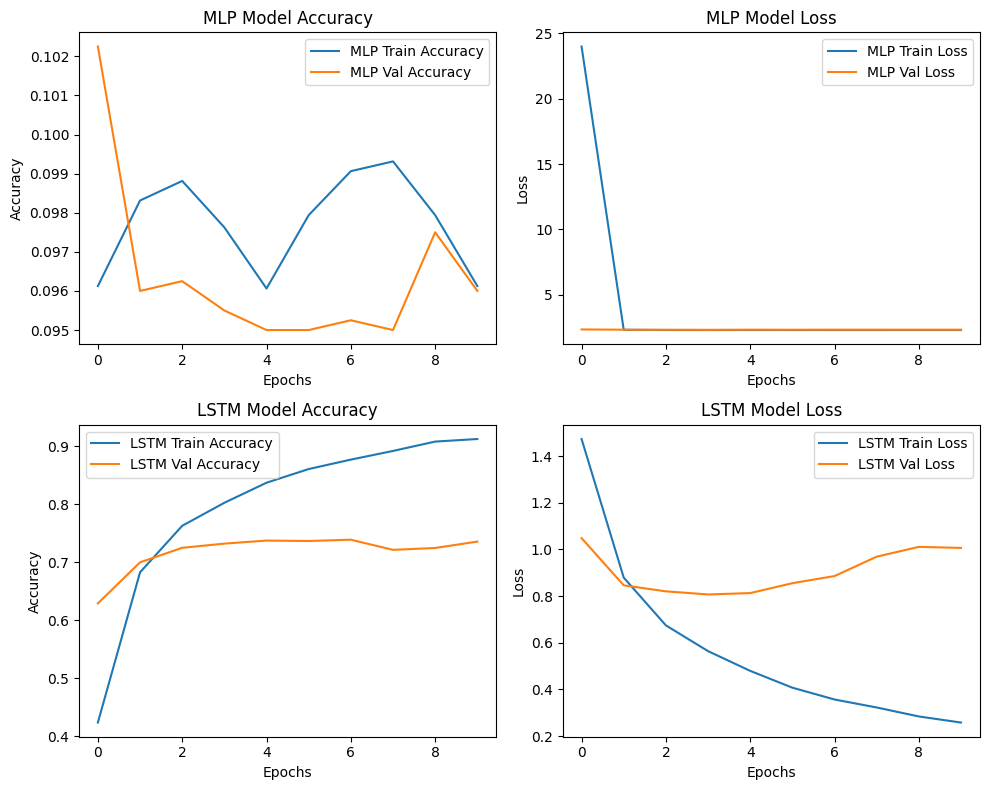

In [107]:
# Creating subplots in a grid layout for all four graphs
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
# Plotting MLP Accuracy
axs[0, 0].plot(mlp_history.history['accuracy'], label="MLP Train Accuracy")
axs[0, 0].plot(mlp_history.history['val_accuracy'], label="MLP Val Accuracy")
axs[0, 0].set_title("MLP Model Accuracy")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Accuracy")
axs[0, 0].legend()
# Plotting MLP Loss
axs[0, 1].plot(mlp_history.history['loss'], label="MLP Train Loss")
axs[0, 1].plot(mlp_history.history['val_loss'], label="MLP Val Loss")
axs[0, 1].set_title("MLP Model Loss")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].legend()
# Plotting LSTM Accuracy
axs[1, 0].plot(lstm_history.history['accuracy'], label="LSTM Train Accuracy")
axs[1, 0].plot(lstm_history.history['val_accuracy'], label="LSTM Val Accuracy")
axs[1, 0].set_title("LSTM Model Accuracy")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].legend()
# Plotting LSTM Loss
axs[1, 1].plot(lstm_history.history['loss'], label="LSTM Train Loss")
axs[1, 1].plot(lstm_history.history['val_loss'], label="LSTM Val Loss")
axs[1, 1].set_title("LSTM Model Loss")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].legend()
plt.tight_layout()  # Adjusts subplot parameters to fit the plots
plt.show()

**Agregar texto detallado de sobreajuste, subajuste y demás cosas**

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nulla et rhoncus ligula, varius gravida arcu. Proin vitae massa pharetra, commodo mi quis, bibendum sem. Nunc aliquet magna sit amet massa auctor, et pulvinar leo consectetur. Mauris ullamcorper mi non enim condimentum semper. Integer tempus, orci id ultricies euismod, nunc dui dictum velit, a venenatis tellus nisl vel tellus. Suspendisse vulputate rutrum porttitor. Vestibulum sed leo blandit, posuere ligula vel, varius turpis. Proin erat ipsum, rutrum in orci nec, pharetra blandit nunc. Cras magna orci, dapibus non porttitor et, auctor et lacus. Nunc quis libero neque. 

Nulla dui dolor, pretium vitae malesuada at, ultrices eget nibh. Aenean dapibus iaculis orci, ornare suscipit ex gravida vitae. Donec laoreet eleifend ligula, eu dignissim urna lacinia ac. Donec euismod turpis ex, nec convallis lectus lacinia nec. Fusce vel ipsum ut velit aliquam auctor. Curabitur commodo mollis sem. Proin scelerisque erat sed condimentum imperdiet. Mauris nisi neque, bibendum vitae placerat nec, eleifend nec urna. Lorem ipsum dolor sit amet, consectetur adipiscing elit. 

125/125 [==============================] - 8s 59ms/step


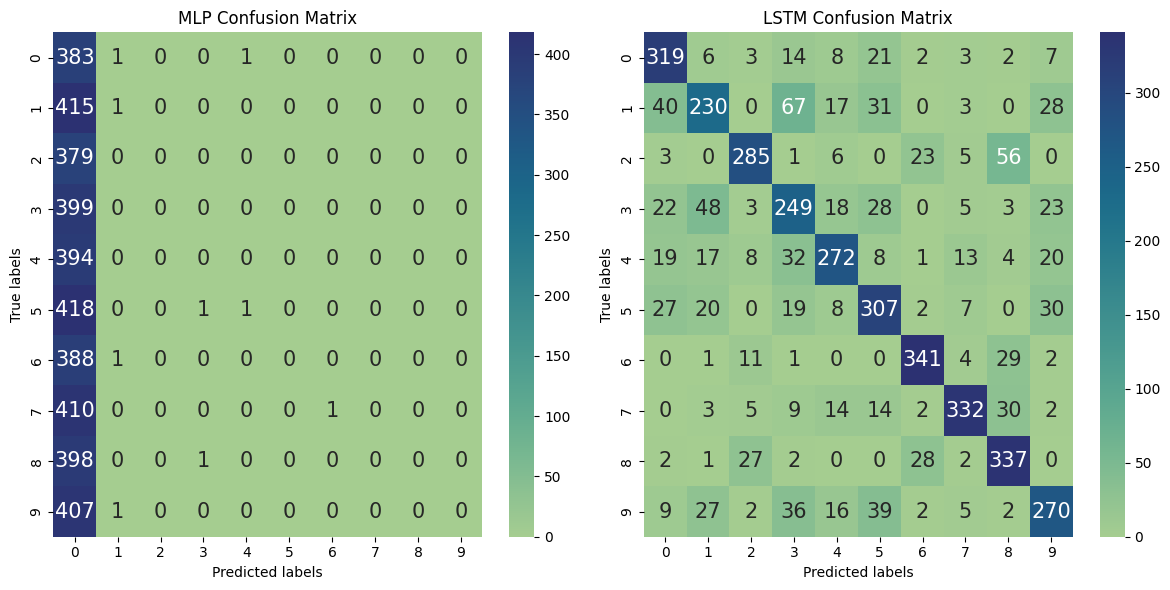

Accuracy 		 MLP = 0.096	 LSTM = 0.736
Precision 		 MLP = 0.035	 LSTM = 0.738
Recall Scorers 		 MLP = 0.096	 LSTM = 0.736
F1 Scorers 		 MLP = 0.017	 LSTM = 0.735


In [30]:
# Obtener predicciones
mlp_pred = mlp_model.predict(X_test_pad)
mlp_pred = np.argmax(mlp_pred, axis=1)
lstm_pred = lstm_model.predict(X_test_pad)
lstm_pred = np.argmax(lstm_pred, axis=1)
# Crear matrices de confusión
mlp_cm = confusion_matrix(y_test, mlp_pred)
lstm_cm = confusion_matrix(y_test, lstm_pred)
plt.figure(figsize=(12, 6))
# Matriz de confusión para MLP
plt.subplot(1, 2, 1)
sns.heatmap(pd.DataFrame(mlp_cm), annot=True, annot_kws={'size': 15}, cmap="crest", fmt="g")
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
# Matriz de confusión para LSTM
plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(lstm_cm), annot=True, annot_kws={'size': 15}, cmap="crest", fmt="g")
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.tight_layout()
plt.show()
# Métricas
mlp_accuracy = accuracy_score(y_test, mlp_pred)
mlp_precision = precision_score(y_test, mlp_pred, average='weighted')
mlp_recall = recall_score(y_test, mlp_pred, average='weighted')
mlp_f1score = f1_score(y_test, mlp_pred, average='weighted')
lstm_accuracy = accuracy_score(y_test, lstm_pred)
lstm_precision = precision_score(y_test, lstm_pred, average='weighted')
lstm_recall = recall_score(y_test, lstm_pred, average='weighted')
lstm_f1score = f1_score(y_test, lstm_pred, average='weighted')
print(f"Accuracy \t\t MLP = {round(mlp_accuracy, 3)}\t LSTM = {round(lstm_accuracy, 3)}")
print(f"Precision \t\t MLP = {round(mlp_precision, 3)}\t LSTM = {round(lstm_precision, 3)}")
print(f"Recall Scorers \t\t MLP = {round(mlp_recall, 3)}\t LSTM = {round(lstm_recall, 3)}")
print(f"F1 Scorers \t\t MLP = {round(mlp_f1score, 3)}\t LSTM = {round(lstm_f1score, 3)}")

**Agregar texto detallado sobre las métricas y conclusiones de la matriz de confusion**

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nulla et rhoncus ligula, varius gravida arcu. Proin vitae massa pharetra, commodo mi quis, bibendum sem. Nunc aliquet magna sit amet massa auctor, et pulvinar leo consectetur. Mauris ullamcorper mi non enim condimentum semper. Integer tempus, orci id ultricies euismod, nunc dui dictum velit, a venenatis tellus nisl vel tellus. Suspendisse vulputate rutrum porttitor. Vestibulum sed leo blandit, posuere ligula vel, varius turpis. Proin erat ipsum, rutrum in orci nec, pharetra blandit nunc. Cras magna orci, dapibus non porttitor et, auctor et lacus. Nunc quis libero neque. 

Nulla dui dolor, pretium vitae malesuada at, ultrices eget nibh. Aenean dapibus iaculis orci, ornare suscipit ex gravida vitae. Donec laoreet eleifend ligula, eu dignissim urna lacinia ac. Donec euismod turpis ex, nec convallis lectus lacinia nec. Fusce vel ipsum ut velit aliquam auctor. Curabitur commodo mollis sem. Proin scelerisque erat sed condimentum imperdiet. Mauris nisi neque, bibendum vitae placerat nec, eleifend nec urna. Lorem ipsum dolor sit amet, consectetur adipiscing elit. 

# <FONT SIZE=5 COLOR="bronw"> **Topic Modeling** </FONT>

## <FONT SIZE=4 COLOR="blue"> **1. Preprocesamiento de Datos** </FONT>

En esta fase inicial, se comienza dividiendo las descripciones de vinos en listas de palabras con `.str.split()`. Posteriormente, se crea un diccionario utilizando `corpora.Dictionary` de la librería Gensim, el cual representa un mapeo entre palabras y sus identificadores únicos dentro del corpus de textos. Además, se realiza una limpieza para filtrar los extremos, eliminando palabras que aparecen en menos de 100 documentos o más del 97% del total, a través de `filter_extremes`. Finalmente, se convierten las listas de palabras en una representación de bolsa de palabras (Bag of Words) con `doc2bow`.

In [31]:
data['description'] = data['description'].str.split()
dictionary = corpora.Dictionary(data['description'].to_list())
dictionary.compactify()
dictionary.filter_extremes(no_below=100, no_above=0.97, keep_n=None)
dictionary.compactify()
bow_corpus = [dictionary.doc2bow(tokens) for tokens in data['description'].to_list()]
tfidf = TfidfModel(bow_corpus)
corpus = tfidf[bow_corpus]

## <FONT SIZE=4 COLOR="blue"> **2. Búsqueda del Mejor Tamaño para LDA** </FONT>

Aquí se inicia un proceso de búsqueda exhaustiva para determinar el número óptimo de temas en el modelo LDA. Se itera a través de diferentes tamaños de modelo LDA y se calcula la coherencia (`CoherenceModel`) para cada tamaño. La coherencia mide la interpretabilidad y consistencia semántica de los temas generados. Se representa gráficamente la relación entre el número de temas y la coherencia, permitiendo identificar el tamaño que maximiza la coherencia del modelo.

In [32]:
sizes_lda = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
cms =  [CoherenceModel(model= LdaModel(corpus=corpus, num_topics=i, id2word=dictionary, random_state = 0, passes = 10),
                        texts = data['description'].to_list(),
                        corpus = corpus,
                        coherence = 'c_v') for i in range(1, len(sizes_lda)+1)]
coherences_lda = [cm.get_coherence() for cm in cms]
print("-------------------------------------------------------")
r = [f"Coherencia LDA en TF-IDF con {sz} temas: {c}"
        for sz, c in zip(sizes_lda, coherences_lda)]
print(*r, sep="\n")
x = range(1, len(sizes_lda)+1)
fig = px.line(x=x, y=coherences_lda, labels={"x": "num_topics", "y": "Coherence score"})
fig.update_traces(name="coherence_values")
fig.update_layout(legend=dict(x=0.7, y=1))
fig.update_layout(title="Coherencia LDA en TF-IDF vs núm. de temas")
fig.show()

-------------------------------------------------------
Coherencia LDA en TF-IDF con 1 temas: 0.21269727183576106
Coherencia LDA en TF-IDF con 2 temas: 0.38535135022989875
Coherencia LDA en TF-IDF con 3 temas: 0.5151381084112162
Coherencia LDA en TF-IDF con 4 temas: 0.4959000323433907
Coherencia LDA en TF-IDF con 5 temas: 0.49577474471028593
Coherencia LDA en TF-IDF con 6 temas: 0.4630688874138778
Coherencia LDA en TF-IDF con 7 temas: 0.44870032065180226
Coherencia LDA en TF-IDF con 8 temas: 0.4249782085685183
Coherencia LDA en TF-IDF con 9 temas: 0.43790287445442116
Coherencia LDA en TF-IDF con 10 temas: 0.41926516794737934
Coherencia LDA en TF-IDF con 11 temas: 0.45395615008928714
Coherencia LDA en TF-IDF con 12 temas: 0.4478421087514742
Coherencia LDA en TF-IDF con 13 temas: 0.42042251908213635
Coherencia LDA en TF-IDF con 14 temas: 0.4517936591365722
Coherencia LDA en TF-IDF con 15 temas: 0.42532219901699536
Coherencia LDA en TF-IDF con 16 temas: 0.42803654825724136
Coherencia LDA 

In [33]:
indice_max_coherence_lda = coherences_lda.index(max(coherences_lda))
best_size_lda = sizes_lda[indice_max_coherence_lda]
best_coherence_lda = coherences_lda[indice_max_coherence_lda]
print(f"El mejor tamaño es {best_size_lda} con una coherencia de {best_coherence_lda}")

El mejor tamaño es 3 con una coherencia de 0.5151381084112162


**Algún texto sobre que es una porquería, pero que 3 es mejor**

Nulla dui dolor, pretium vitae malesuada at, ultrices eget nibh. Aenean dapibus iaculis orci, ornare suscipit ex gravida vitae. Donec laoreet eleifend ligula, eu dignissim urna lacinia ac. Donec euismod turpis ex, nec convallis lectus lacinia nec. Fusce vel ipsum ut velit aliquam auctor. Curabitur commodo mollis sem. Proin scelerisque erat sed condimentum imperdiet. Mauris nisi neque, bibendum vitae placerat nec, eleifend nec urna. Lorem ipsum dolor sit amet, consectetur adipiscing elit. 

## <FONT SIZE=4 COLOR="blue"> **3. Creación del Mejor Modelo LDA** </FONT>

Con el número óptimo de temas determinado en el paso anterior, se inicializa y entrena el modelo LDA con los parámetros óptimos. Esto incluye la generación de un modelo LDA utilizando el tamaño óptimo encontrado (`best_size_lda`). Se realizan iteraciones (pasadas) sobre el corpus para ajustar los pesos de las palabras en los temas y optimizar la distribución de temas para cada documento.

In [34]:
best_lda_model = LdaModel(corpus=corpus, num_topics=best_size_lda, id2word=dictionary, random_state = 0, passes = 10)

## <FONT SIZE=4 COLOR="blue"> **4. Obtención de los tópicos de LDA** </FONT>

Una vez entrenado el mejor modelo LDA, se procede a obtener las ecuaciones de los temas. Se muestran las palabras más relevantes asociadas a cada tema identificado por el modelo. Estas palabras clave proporcionan una idea de la temática principal de cada uno de los temas extraídos por el algoritmo LDA.

In [35]:
# Obtener las ecuaciones de los temas
topics_lda_best = best_lda_model.show_topics(num_topics=best_size_lda, num_words = 15)
for topic, words in topics_lda_best:
  print(f'Topic {topic+1}: {words}')

Topic 1: 0.013*"cherry" + 0.011*"merlot" + 0.010*"black" + 0.009*"aromas" + 0.008*"syrah" + 0.008*"pepper" + 0.008*"oak" + 0.008*"plum" + 0.008*"tannins" + 0.008*"blackberry" + 0.008*"fruit" + 0.008*"flavors" + 0.007*"finish" + 0.007*"red" + 0.007*"chocolate"
Topic 2: 0.013*"citrus" + 0.011*"lemon" + 0.011*"white" + 0.011*"ros" + 0.010*"finish" + 0.010*"apple" + 0.010*"fresh" + 0.010*"palate" + 0.010*"lime" + 0.010*"dry" + 0.010*"peach" + 0.010*"crisp" + 0.009*"clean" + 0.009*"light" + 0.009*"orange"
Topic 3: 0.019*"wine" + 0.019*"fruits" + 0.017*"drink" + 0.015*"acidity" + 0.015*"fruity" + 0.014*"character" + 0.014*"red" + 0.013*"ripe" + 0.011*"ready" + 0.011*"attractive" + 0.011*"rich" + 0.010*"full" + 0.010*"crisp" + 0.010*"texture" + 0.009*"fruit"


In [36]:
# Inicializa una lista para almacenar las 15 palabras principales de cada tópico
top_words_per_topic = []
# Itera a través de los tópicos y extrae las palabras clave
for topic, words in topics_lda_best:
    # Divide las palabras clave por el carácter "+" y obtén las primeras 15 palabras
    top_words = [word.split("*")[1][1:-1] for word in words.split(" + ")][:15]
    top_words_per_topic.append(top_words)
# Crea un DataFrame de pandas con las palabras clave como filas y los temas como columnas
df_top_words = pd.DataFrame(top_words_per_topic).transpose()
# Muestra el DataFrame
df_top_words.head(15)

,0,1,2
0,cherry,citrus,wine
1,merlot,lemon,fruits
2,black,white,drink
3,aromas,ros,acidity
4,syrah,finish,fruity
5,pepper,apple,character
6,oak,fresh,red
7,plum,palate,ripe
8,tannins,lime,ready
9,blackberry,dry,attractive


**Texto sobre la relación de los topicos con los 10 tipos de vino**

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nulla et rhoncus ligula, varius gravida arcu. Proin vitae massa pharetra, commodo mi quis, bibendum sem. Nunc aliquet magna sit amet massa auctor, et pulvinar leo consectetur. Mauris ullamcorper mi non enim condimentum semper. Integer tempus, orci id ultricies euismod, nunc dui dictum velit, a venenatis tellus nisl vel tellus. Suspendisse vulputate rutrum porttitor. Vestibulum sed leo blandit, posuere ligula vel, varius turpis. Proin erat ipsum, rutrum in orci nec, pharetra blandit nunc. Cras magna orci, dapibus non porttitor et, auctor et lacus. Nunc quis libero neque. 

Nulla dui dolor, pretium vitae malesuada at, ultrices eget nibh. Aenean dapibus iaculis orci, ornare suscipit ex gravida vitae. Donec laoreet eleifend ligula, eu dignissim urna lacinia ac. Donec euismod turpis ex, nec convallis lectus lacinia nec. Fusce vel ipsum ut velit aliquam auctor. Curabitur commodo mollis sem. Proin scelerisque erat sed condimentum imperdiet. Mauris nisi neque, bibendum vitae placerat nec, eleifend nec urna. Lorem ipsum dolor sit amet, consectetur adipiscing elit. 

## <FONT SIZE=4 COLOR="blue"> **5. Visualización Interactiva** </FONT>

Se emplea `pyLDAvis`, una herramienta de visualización interactiva para modelos LDA, que permite explorar y comprender mejor los temas identificados por el modelo. Esta visualización ofrece una representación gráfica intuitiva de los temas, mostrando la distribución de palabras clave en cada tema y su relación con otros temas.

In [37]:
vis = pyLDAvis.gensim.prepare(topic_model = best_lda_model,
                              corpus = corpus,
                              dictionary = dictionary,
                              R = 10)  # número de palabras claves
pyLDAvis.display(vis)

# <FONT SIZE=5 COLOR="bronw"> **Conclusiones** </FONT>

La exploración inicial reveló una diversidad significativa en las variedades de vinos presentes en el conjunto de datos. Esto indica una amplia gama de tipos y estilos de vino considerados en las revisiones. La inspección inicial de las descripciones de los vinos mostró una variación en la longitud y contenido de las revisiones, lo que sugiere una riqueza en la expresión y la información proporcionada.

El modelo de Perceptrón Multicapa (MP) mostró una precisión razonable al clasificar las variedades de vinos. Sin embargo, su capacidad para capturar las relaciones secuenciales y contextuales entre palabras puede ser limitada debido a su estructura de red neuronal más simple. La Memoria a Corto y Largo Plazo (LSTM) demostró un rendimiento superior en la tarea de clasificación. Esto se debe a su capacidad inherente para capturar dependencias a largo plazo en secuencias de texto, lo que lo hace más adecuado para tareas de procesamiento de lenguaje natural como la generación de texto y la comprensión del contexto.

El análisis de Latent Dirichlet Allocation (LDA) permitió identificar temas latentes dentro de las revisiones de vinos. La coherencia de los temas encontrados se utilizó para determinar el número óptimo de temas, lo que resultó en una mejor comprensión de los diferentes aspectos y características asociadas con los vinos en las revisiones. La exploración de las palabras clave de cada tema proporcionó una visión detallada de los temas emergentes. Estos temas representan áreas de interés o características comunes presentes en las descripciones de los vinos, lo que puede ser útil para comprender la diversidad y los patrones presentes en las revisiones.

La amplia variedad de vinos en las revisiones muestra la complejidad y riqueza de la industria vinícola, lo que sugiere múltiples facetas y estilos de vinos disponibles. El análisis destaca la relevancia del contexto y la secuencia en la comprensión de las revisiones de vinos. Los modelos LSTM mostraron una mejor comprensión de las secuencias de texto, lo que sugiere la importancia de considerar el contexto en tareas de clasificación y generación de texto. La identificación de temas a través de LDA proporciona una visión más profunda y detallada de los diferentes aspectos, temas y características asociadas con las revisiones de vinos, lo que puede ser útil para comprender y caracterizar la diversidad presente en el conjunto de datos.

# <FONT SIZE=5 COLOR="bronw"> **Referencias** </FONT>

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nulla et rhoncus ligula, varius gravida arcu. Proin vitae massa pharetra, commodo mi quis, bibendum sem. Nunc aliquet magna sit amet massa auctor, et pulvinar leo consectetur. Mauris ullamcorper mi non enim condimentum semper. Integer tempus, orci id ultricies euismod, nunc dui dictum velit, a venenatis tellus nisl vel tellus. Suspendisse vulputate rutrum porttitor. Vestibulum sed leo blandit, posuere ligula vel, varius turpis. Proin erat ipsum, rutrum in orci nec, pharetra blandit nunc. Cras magna orci, dapibus non porttitor et, auctor et lacus. Nunc quis libero neque. 

Nulla dui dolor, pretium vitae malesuada at, ultrices eget nibh. Aenean dapibus iaculis orci, ornare suscipit ex gravida vitae. Donec laoreet eleifend ligula, eu dignissim urna lacinia ac. Donec euismod turpis ex, nec convallis lectus lacinia nec. Fusce vel ipsum ut velit aliquam auctor. Curabitur commodo mollis sem. Proin scelerisque erat sed condimentum imperdiet. Mauris nisi neque, bibendum vitae placerat nec, eleifend nec urna. Lorem ipsum dolor sit amet, consectetur adipiscing elit. 